In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import random
from scipy.stats import multivariate_normal

## General classes

In [2]:
class Environment:
    def __init__(self):
        pass

    def round(self, product_price):
        pass

In [3]:
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, reward_t):
        pass

### Requirement 1: single product and stochastic environment

#### Environment

In [ ]:
class SingleProductEnvironment(Environment):
  def __init__(self, T, valuation_distr=stats.uniform):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = valuation_distr.rvs(size=T)

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

#### Agent without inventory constraint - UCB1

In [ ]:
class UCB1(Agent):
    def __init__(self, T, prices, range=1):
        self.range = range # Range of the reward
        self.P = len(prices) # Prices' set cardinality
        self.T = T # Number of rounds
        self.pi_t = None # Init price

        self.average_rewards = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)

        self.t = 0 # Starting round

    def pull_arm(self):
        # Check if the round is less then number of prices
        if self.t < self.P:
            # then set it as product_price
            self.pi_t = self.t
        else:
            # Compute UCB1
            ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls)

            # Extract the price that maximizes the UCB1
            self.pi_t = np.argmax(ucbs)

        return self.pi_t

    def update(self, reward):
        self.N_pulls[self.pi_t] += 1

        # As average, we have (total purchasing) / (number of times of purchasing)
        self.average_rewards[self.pi_t] += (reward - self.average_rewards[self.pi_t])/self.N_pulls[self.pi_t]
        self.t += 1

#### Clairvoyant without inventory constraint

In [ ]:
class SingleProductStochasticClairvoyant:
    def __init__(self, T, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [ ]:
# Parameters
T = 10000

# Prices
max_price = 1
price_step = T ** (-1/3)
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 1
#valuation_distr = stats.binom(loc=0, n=max_valuation, p=0.5)
valuation_distr = stats.uniform(loc=0, scale=max_price)

In [ ]:
# Run clairvoyant
clairvoyant = SingleProductStochasticClairvoyant(T, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T, valuation_distr)
  ucb_like_agent = UCB1(T, prices, range=max_price)

  agent_rewards = []

  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)

  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

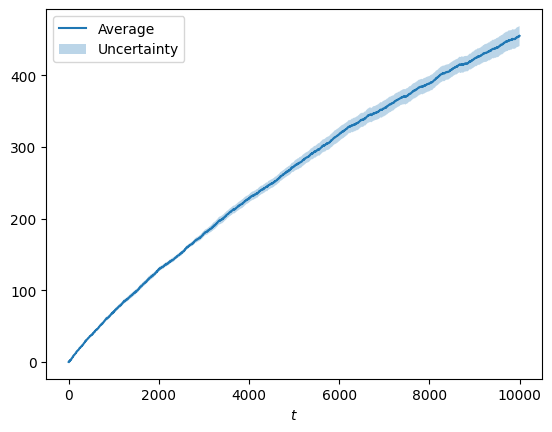

In [ ]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

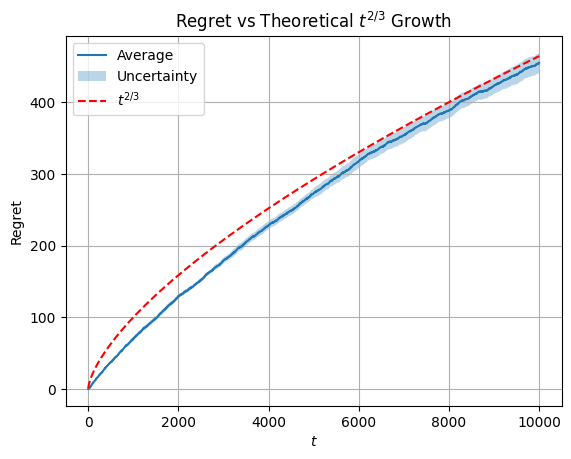

In [ ]:
average_regret = regret_per_trial.mean(axis=0)  # media
regret_sd = regret_per_trial.std(axis=0)        # deviazione standard

t = np.arange(1, T+1)  # inizia da 1 per evitare t^{2/3} = 0^{2/3} = 0
regret_theory = t**(2/3)

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$t^{2/3}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.title("Regret vs Theoretical $t^{2/3}$ Growth")
plt.grid(True)
plt.show()

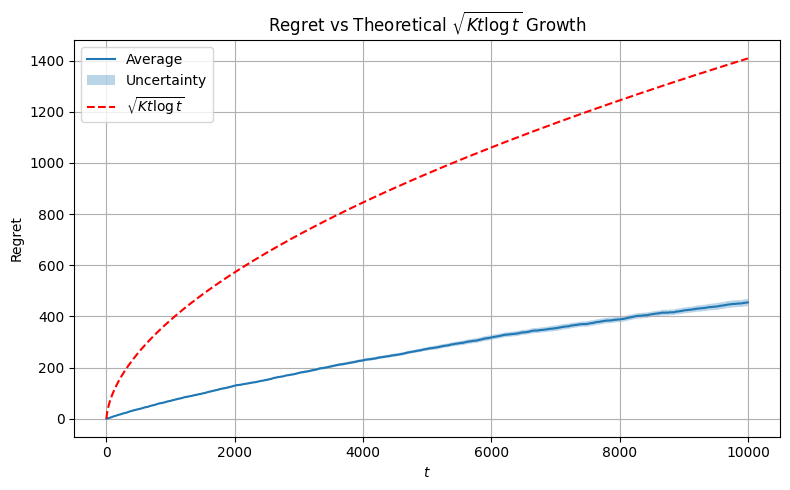

In [ ]:
K= 1/price_step
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = np.sqrt(K * t * np.log(t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)

# Aggiunta curva asintotica
plt.plot(t - 1, theoretical_curve, label=r"$\sqrt{K t \log t}$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical $\sqrt{K t \log t}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Agent with inventory constraint - UCB-like

In [ ]:
class UCBLike():
    def __init__(self, T, B, prices, range=1):
        self.T = T
        self.P = len(prices)
        self.range = range

        self.pi_t = None
        self.avg_f = np.zeros(self.P)
        self.avg_c = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)
        self.budget = B

        self.t = 0

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            self.pi_t = 0
            return 0

        if self.t < self.P:
            self.pi_t = self.t
        else:
            # Upper Confidence Bound
            f_ucbs = self.avg_f + self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Lower Confidence Bound
            c_lcbs = self.avg_c - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Price optimal distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)

            # Set current price
            self.pi_t = np.random.choice(self.P, p=gamma_t)

        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma

        c = -f_ucbs

        A_ub = [c_lcbs]
        rho = self.budget/self.T
        b_ub = [rho]

        A_eq = [np.ones(self.P)]
        b_eq = [1]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))

        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        # Update the number of pulled price
        self.N_pulls[self.pi_t] += 1

        # Update averages
        self.avg_f[self.pi_t] = self.avg_f[self.pi_t] + (f_t - self.avg_f[self.pi_t])/self.N_pulls[self.pi_t]
        self.avg_c[self.pi_t] = self.avg_c[self.pi_t] + (c_t - self.avg_c[self.pi_t])/self.N_pulls[self.pi_t]

        # Update budget
        self.budget = self.budget - c_t

        self.t += 1

#### Clairvoyant with inventory constraint

In [ ]:
class SingleProductStochasticInventoryClaivoyant:
    def __init__(self, T, budget, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices
        self.budget = budget

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob]
        rho = self.budget/self.T
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [ ]:
# Parameters
T = 10000
B = T * 3/4

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 1
valuation_distr = stats.uniform(loc=0, scale=max_price)

In [ ]:
# Run clairvoyant
clairvoyant = SingleProductStochasticInventoryClaivoyant(T, B, prices, valuation_distr)

expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 20
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T)
  ucb_like_agent = UCBLike(T, B, prices, range=max_price)

  agent_rewards = []
  for t in range(T):
    if(B<=0):
      break
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t, r_t > 0)

    agent_rewards.append(r_t)
    if(r_t>0):
      B = B - 1

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

ValueError: operands could not be broadcast together with shapes (10000,) (5508,) 

In [ ]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

In [ ]:
ucb_like_agent.budget

In [ ]:
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = np.sqrt(t)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)


plt.plot(t - 1, theoretical_curve, label=r"$\sqrt{t }$", linestyle="--", color="red")


plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical $\sqrt{ t}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Requirement 2: multiple products and stochastic environment

In [ ]:
class MultipleProductEnvironment(Environment):
  def __init__(self, T, N, max_valuation):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    # Valuation of each buyer sampled from the given distribution function
    self.valuations = np.random.uniform(0, max_valuation, size=(T, N))

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

### Requirement 3: best-of-both-worlds algorithms with a single product

In [ ]:
def getDistribution():
    arr = np.arange(0.2, 2, 0.2)
    random_index_a = random.randint(0, len(arr) - 1)
    random_index_b = random.randint(0, len(arr) - 1)

    return stats.beta(arr[random_index_a], arr[random_index_b])

In [ ]:
def getDistribution():
    a = stats.uniform(loc=0, scale=2).rvs()
    b = stats.uniform(loc=0, scale=2).rvs()

    return stats.beta(a,b)

In [ ]:
def getDistribution():
    choice = np.random.choice(['beta', 'gaussian', 'uniform'])

    if choice == 'beta':
        arr = np.arange(0.5, 6, 0.5)  # valori tra 0.5 e 5.5
        a = np.random.choice(arr)
        b = np.random.choice(arr)
        return stats.beta(a, b)

    elif choice == 'gaussian':
        mean = np.random.uniform(0.3, 0.8)
        std = np.random.uniform(0.05, 0.2)
        a, b = (0 - mean) / std, (1 - mean) / std
        return stats.truncnorm(a, b, loc=mean, scale=std)

    elif choice == 'uniform':
        low = np.random.uniform(0.1, 0.6)
        high = np.random.uniform(low + 0.1, 1.0)
        return stats.uniform(loc=low, scale=high - low)

In [ ]:
def getDistribution():
    arr = np.arange(2, 6, 1)  # valori tra 2 e 7
    a = np.random.choice(arr)
    b = np.random.choice(arr)
    return stats.beta(a, b)

#### Environment

In [ ]:
class SingleProductHighlyNonStationaryEnvironment(Environment):
  def __init__(self, T, valuation_distr):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = [valuation_distr[i].rvs() for i in range(T)]

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

#### Clairvoyant

In [ ]:
class SingleProductHighltyNonStationaryClairvoyant:
    def __init__(self, T, B, prices, valuation_distr):
        self.T = T
        self.prices = prices
        self.B=B
        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product

        selling_prob = [1 - self.valuation_distr[i].cdf(self.prices) for i in range(T)]
        selling_prob_mean=np.mean(selling_prob, axis=0)

        ## Liner programming
        c = - self.prices * selling_prob_mean # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob_mean]
        rho=self.B/self.T
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0,1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

##### Clairvoyant 2

In [ ]:
import numpy as np
from scipy import optimize

class WindowedClairvoyant:
    def __init__(self, T, B, prices, valuation_distr, window_size=50):
        self.T = T
        self.B = B
        self.prices = prices
        self.valuation_distr = valuation_distr
        self.window_size = window_size

    def run(self):
        K = len(self.prices)
        x = np.zeros((self.T, K))  # strategia per ogni turno e prezzo
        M = self.T // self.window_size
        rho = self.B / self.T  # budget medio per turno

        for w in range(M):
            start = w * self.window_size
            end = start + self.window_size

            avg_cdf = np.zeros(K)
            for t in range(start, end):
                avg_cdf += self.valuation_distr[t].cdf(self.prices)
            avg_cdf /= self.window_size

            selling_prob = 1 - avg_cdf
            c = - self.prices * selling_prob

            A_eq = [np.ones(K)]
            b_eq = [1]
            A_ub = [selling_prob]
            b_ub = [rho]
            bounds = [(0, 1) for _ in range(K)]

            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            if not res.success:
                print(f"Warning: LP non ha convergito per finestra {w}")
                x_w = np.ones(K) / K
            else:
                x_w = res.x

            for t in range(start, end):
                x[t, :] = x_w

        # Gestione resto se T non multiplo di window_size
        if self.T % self.window_size != 0:
            start = M * self.window_size
            end = self.T
            window_len = end - start

            avg_cdf = np.zeros(K)
            for t in range(start, end):
                avg_cdf += self.valuation_distr[t].cdf(self.prices)
            avg_cdf /= window_len

            selling_prob = 1 - avg_cdf
            c = - self.prices * selling_prob

            A_eq = [np.ones(K)]
            b_eq = [1]
            A_ub = [selling_prob]
            b_ub = [rho]
            bounds = [(0, 1) for _ in range(K)]

            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            if not res.success:
                print("Warning: LP non ha convergito per finestra finale")
                x_w = np.ones(K) / K
            else:
                x_w = res.x

            for t in range(start, end):
                x[t, :] = x_w

        # Calcolo expected utilities per turno
        expected_utilities = np.zeros(self.T)
        for t in range(self.T):
            selling_prob_t = 1 - self.valuation_distr[t].cdf(self.prices)
            expected_utilities[t] = np.sum(x[t, :] * self.prices * selling_prob_t)

        return expected_utilities #, x

#### Agent

In [ ]:
class EXP3Agent(Agent):
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [ ]:
class FFMultiplicativePacingAgent(Agent):
    def __init__(self, prices_set, budget, T, eta, learning_rate):
        self.prices_set = prices_set
        self.K = len(prices_set)
        self.learning_rate = learning_rate
        self.exp3 = EXP3Agent(self.K, self.learning_rate)
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T + 1.5
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(prices_set))
        self.price_index = 0
        self._lambdas = []

    def pull_arm(self):
        if self.budget < 1:
            return 1.1

        self.price_index = self.exp3.pull_arm()
        return self.prices_set[self.price_index]

    def update(self, f_t):
        #self.rho = self.budget/(self.T-self.t+1)
        c_t = int(f_t > 0)
        L = f_t - self.lmbd*(c_t-self.rho)

        # linear rescale in the feasible interval
        L_up = 1 -(1/self.rho)*(-self.rho)
        L_low = 0 -(1/self.rho)*(1-self.rho)
        rescaled_L = (L - L_low)/(L_up-L_low)
        self.exp3.update(1 - rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)

        self._lambdas.append((self.lmbd, c_t))

        # update budget
        self.budget -= c_t

        self.N_pulls[self.price_index] += 1

    def get_budget(self):
      return self.budget

    def lambdas(self):
      return self._lambdas

#### Prove agent

In [ ]:
class EXP3PAgent(Agent):
    def __init__(self, K, T, alpha, gamma):
        self.K = K                      # Numero di bracci
        self.T = T                      # Orizzonte
        self.alpha = alpha              # Parametro α > 0
        self.gamma = gamma              # Parametro γ ∈ (0,1]

        # Inizializzazione dei pesi
        init_weight = np.exp((alpha * gamma / 3) * np.sqrt(T / K))
        self.weights = np.full(K, init_weight)

        self.t = 0                      # Tempo
        self.x_t = np.ones(K) / K      # Distribuzione iniziale
        self.a_t = None                # Azione scelta

    def pull_arm(self):
        # Passo 1: Calcolo delle probabilità p_i(t)
        weight_sum = np.sum(self.weights)
        self.x_t = (1 - self.gamma) * (self.weights / weight_sum) + self.gamma / self.K

        # Passo 2: Seleziona l'azione
        self.a_t = np.random.choice(self.K, p=self.x_t)
        return self.a_t

    def update(self, reward):
        # Passo 3: reward osservato ∈ [0,1]
        # Passo 4: Stima del reward (importance-weighted)
        estimated_reward = np.zeros(self.K)
        estimated_reward[self.a_t] = reward / self.x_t[self.a_t]

        # Passo 5: Aggiornamento dei pesi
        for j in range(self.K):
            bonus = self.alpha / self.x_t[j] * np.sqrt(self.K / self.T)
            exponent = (self.gamma / (3 * self.K)) * (estimated_reward[j] + bonus)
            self.weights[j] *= np.exp(exponent)

        self.t += 1

In [ ]:
import numpy as np

class EXP3P_Bandit_Agent(Agent):
    def __init__(self, N, eta, alpha, gamma):
        self.N = N                  # Numero di azioni (bracci)
        self.alpha = alpha            # Stabilizzazione
        self.eta = eta              # Learning rate
        self.gamma = gamma          # Esplorazione
        self.weights = np.ones(N)   # Pesi iniziali
        self.p = np.ones(N) / N     # Distribuzione iniziale
        self.last_action = None
        self.t = 0

    def pull_arm(self):
        self.last_action = np.random.choice(self.N, p=self.p)
        return self.last_action

    def update(self, observed_reward):
        i = self.last_action
        g_tilde = np.zeros(self.N)

        # Solo il braccio selezionato riceve reward stimato
        g_tilde[i] = (observed_reward + self.alpha) / self.p[i]

        # Gli altri ricevono solo bonus β / p_i
        for j in range(self.N):
            if j != i:
                g_tilde[j] = self.alpha / self.p[j]

        # Aggiorna pesi
        self.weights *= np.exp(self.eta * g_tilde)

        # Ricalcola distribuzione con smoothing
        W_t = np.sum(self.weights)
        self.p = (1 - self.gamma) * (self.weights / W_t) + self.gamma / self.N

        self.t += 1


In [ ]:
delta = 0.05
alpha = np.sqrt( (1 / (T * K)) * np.log(K / delta) )
gamma = (4 * K * alpha) / (3 + alpha)
eta = gamma / (2 * K)

#### Parameters

In [ ]:
# Parameters
T = 50000
B = T * 50/100

# Prices
max_price = 1.1
price_step = 0.1
prices = np.arange(0.1, max_price, price_step)
K = len(prices)
# Valuation prob. distribution
max_valuation = 1

In [ ]:
prices

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
#adversarial
learning_rate = np.sqrt(np.log(K)/(K*T))  #learning rate EXP3
eta=1/np.sqrt(T)   #learing rate Multiplicative pacing

valuation_distributions = []
for t in range(T):
  distr = getDistribution()
  valuation_distributions.append(distr)


In [ ]:
#stationary
learning_rate = np.sqrt(np.log(K)/(K*T))  #learning rate EXP3
eta=1/np.sqrt(T)   #learing rate Multiplicative pacing

distr = getDistribution()
valuation_distributions = []
for t in range(T):
  valuation_distributions.append(distr)

In [ ]:
from collections import Counter

# Calcola media e varianza per ogni distribuzione
mean_var_pairs = []

for dist in valuation_distributions:
    mean, var = dist.stats(moments='mv')
    mean = float(np.round(mean, 4))  # arrotondo per evitare problemi di float
    var = float(np.round(var, 4))
    mean_var_pairs.append((mean, var))

# Conta quante volte appaiono le coppie (mean, var)
count_mv = Counter(mean_var_pairs)

# Stampa solo quelle diverse (una volta ciascuna, con frequenza)
print("Distribuzioni distinte (media, varianza) e frequenze:")
for (mean, var), count in sorted(count_mv.items()):
    print(f"mean={mean:.4f}, var={var:.4f} → {count} volte")

means = [m for m, v in mean_var_pairs]

print(f"Valore medio sample: {np.mean(means):.3f}")
print(f"Valore minimo sample: {np.min(means):.3f}")
print(f"Valore massimo sample: {np.max(means):.3f}")

Output streaming troncato alle ultime 5000 righe.
mean=0.6961, var=0.0054 → 1 volte
mean=0.6961, var=0.0072 → 1 volte
mean=0.6961, var=0.0081 → 1 volte
mean=0.6961, var=0.0096 → 1 volte
mean=0.6961, var=0.0104 → 1 volte
mean=0.6961, var=0.0190 → 1 volte
mean=0.6961, var=0.0204 → 1 volte
mean=0.6961, var=0.0258 → 1 volte
mean=0.6962, var=0.0065 → 1 volte
mean=0.6962, var=0.0073 → 1 volte
mean=0.6962, var=0.0077 → 2 volte
mean=0.6962, var=0.0085 → 1 volte
mean=0.6962, var=0.0123 → 1 volte
mean=0.6962, var=0.0136 → 1 volte
mean=0.6962, var=0.0160 → 1 volte
mean=0.6962, var=0.0259 → 1 volte
mean=0.6962, var=0.0302 → 1 volte
mean=0.6963, var=0.0072 → 1 volte
mean=0.6963, var=0.0073 → 1 volte
mean=0.6963, var=0.0074 → 1 volte
mean=0.6963, var=0.0082 → 1 volte
mean=0.6963, var=0.0121 → 2 volte
mean=0.6963, var=0.0180 → 1 volte
mean=0.6963, var=0.0181 → 1 volte
mean=0.6963, var=0.0283 → 1 volte
mean=0.6964, var=0.0053 → 1 volte
mean=0.6964, var=0.0155 → 1 volte
mean=0.6964, var=0.0159 → 1 volt

In [ ]:
prices_arr = []
rewards = []
budget_per_trial =[]

residual_budget = []

# Run clairvoyant
# clairvoyant = SingleProductHighltyNonStationaryClairvoyant(T, B, prices, valuation_distributions)
clairvoyant=WindowedClairvoyant(T, B, prices, valuation_distributions, window_size=50)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductHighlyNonStationaryEnvironment(T, valuation_distributions)
  multiplicative_pacing_agent = FFMultiplicativePacingAgent(prices, B, T, eta, learning_rate)
  count = 0
  agent_rewards = []
  budget=[]
  for t in range(T):
    if(count>=B):
      r_t = 0
      agent_rewards.append(r_t)
    else:
      # Get the actual price
      p_t = multiplicative_pacing_agent.pull_arm()
      # Get reward
      r_t = env.round(p_t)

      prices_arr.append(p_t)
      rewards.append(r_t)

      # Update agent state
      multiplicative_pacing_agent.update(r_t)

      agent_rewards.append(r_t)
      if(r_t > 0):
        count = count + 1
    budget.append(multiplicative_pacing_agent.get_budget())
  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)
  budget_per_trial.append(budget)

  residual_budget.append(multiplicative_pacing_agent.get_budget())

regret_per_trial = np.array(regret_per_trial)

In [ ]:
from collections import Counter

price_counts = Counter(prices_arr)

print("Frequenze dei prezzi scelti:")
for price in sorted(price_counts):
    print(f"Prezzo {price:.2f}: scelto {price_counts[price]} volte")

Frequenze dei prezzi scelti:
Prezzo 0.10: scelto 7847 volte
Prezzo 0.20: scelto 18296 volte
Prezzo 0.30: scelto 56539 volte
Prezzo 0.40: scelto 134140 volte
Prezzo 0.50: scelto 109991 volte
Prezzo 0.60: scelto 42083 volte
Prezzo 0.70: scelto 16284 volte
Prezzo 0.80: scelto 9617 volte
Prezzo 0.90: scelto 5997 volte
Prezzo 1.00: scelto 5878 volte


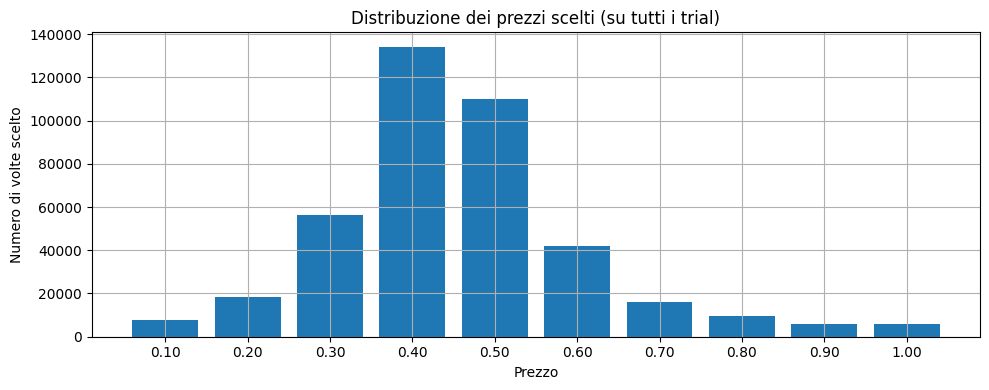

In [ ]:
import matplotlib.pyplot as plt

# Ordina per prezzo crescente
sorted_prices = sorted(price_counts)
counts = [price_counts[p] for p in sorted_prices]

plt.figure(figsize=(10, 4))
plt.bar([f"{p:.2f}" for p in sorted_prices], counts)
plt.xlabel("Prezzo")
plt.ylabel("Numero di volte scelto")
plt.title("Distribuzione dei prezzi scelti (su tutti i trial)")
plt.grid(True)
plt.tight_layout()
plt.show()


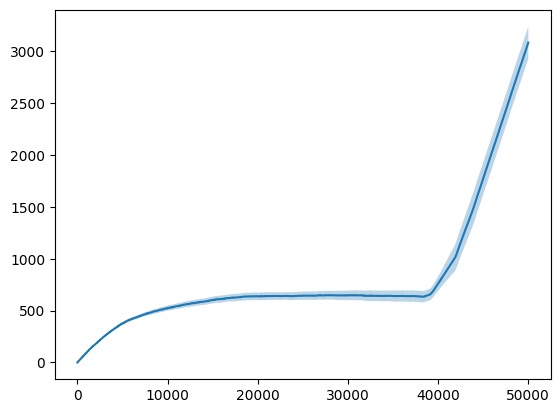

In [ ]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation
average_budget = np.array(budget_per_trial).mean(axis=0)
budget_sd = np.array(budget_per_trial).std(axis=0)

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)


/tmp/ipython-input-171-2470661149.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


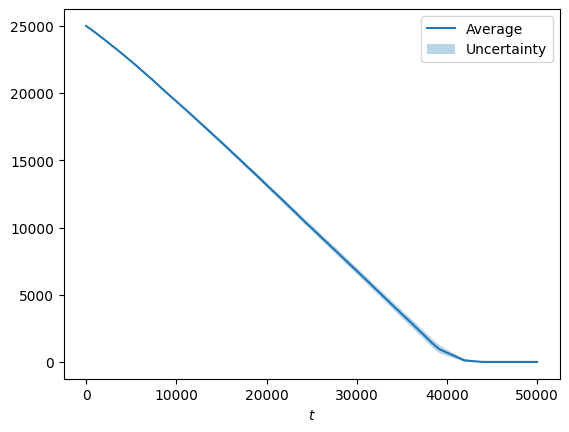

In [ ]:
plt.xlabel("$t$")
plt.legend()

plt.plot(np.arange(T), average_budget, label="Average")
plt.fill_between(
    np.arange(T),
    average_budget-budget_sd/np.sqrt(n_trials),
    average_budget+budget_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

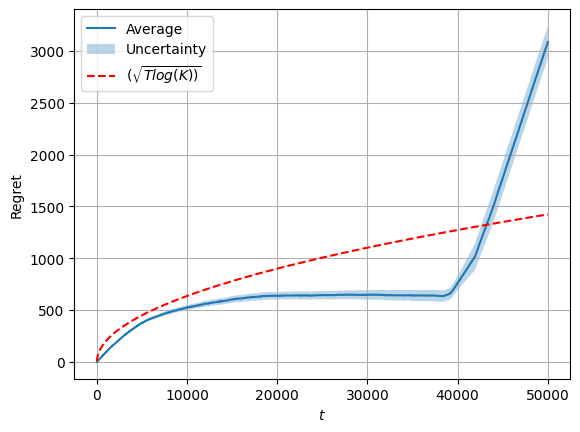

In [ ]:
average_regret = regret_per_trial.mean(axis=0)  # media
regret_sd = regret_per_trial.std(axis=0)        # deviazione standard

t = np.arange(1, T+1)  # inizia da 1 per evitare t^{2/3} = 0^{2/3} = 0
regret_theory = (900 / np.sqrt(20000*np.log(K))) * np.sqrt(t*np.log(K))

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$(\sqrt{Tlog(K))}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.grid(True)
plt.show()

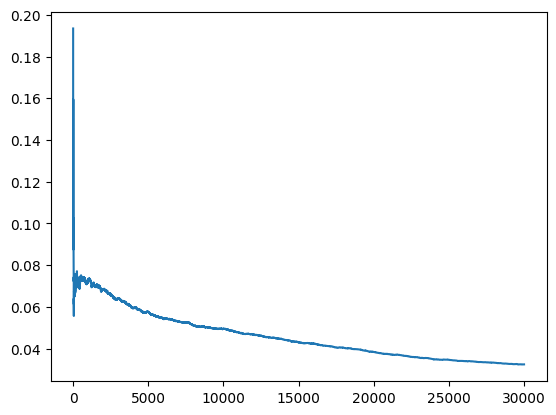

In [ ]:
diff = average_regret / t
plt.plot(t, diff, label="andament")

In [ ]:
np.array(residual_budget)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
residual_budget_mean = np.array(residual_budget).mean()
print(np.sqrt(np.var(residual_budget)))
print(residual_budget_mean)

print(residual_budget_mean / B)

0.0
0.0
0.0


### Requirement 4: best-of-both-worlds algorithms with multiple products

In [ ]:
# Parameters
T = 50000
B = T * 50/100

# Prices
max_price = 1.1
price_step = 0.1
prices = np.arange(0.1, max_price, price_step)
K = len(prices)
# Valuation prob. distribution
max_valuation = 1

N = 5

#### Environment

In [4]:
#valuations_distr is a list long T that contains for each round the multivariate normal distribution of each product
class MultipleProductHiglyNonStationaryEnvironment(Environment):
  def __init__(self, T, N, valuations_distr):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer


    # Valuation of each buyer sampled from the given distribution function:
    # TxN matrix, so for each round t we have the different valuations of each product n
    self.valuations = np.array([distr.rvs() for distr in valuations_distr])

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

#### Agent

it uses the EXP3Agent defined in requirement 3

In [5]:
class MultipleProductMultiplicativePAcingAgent(Agent):
    def __init__(self, prices_set, budget, T, N, eta, learning_rate):
        self.prices_set = prices_set
        self.K = len(prices_set)
        self.learning_rate = learning_rate
        self.eta=eta
        self.budget = budget
        self.T=T
        #a different exp3 agent for every product
        self.exp3_list = [EXP3Agent(self.K, self.learning_rate) for _ in range(self.N)]

        self.rho = self.budget / self.T + 1.5     # Per round budget
        self.lmbd = 1                              # Shared lambda
        self.t = 0
        self.N_pulls = np.zeros((self.N, self.K)) # Count arm pulls per product
        self.price_index = 0
        self._lambdas = []

    def pull_arm(self):
        if self.budget < 1:
            self.p_t = np.array([1.1 for _ in range(self.N)])
            return self.p_t

        chosen_prices = []
        for i in range(self.N):
            self.price_index = self.exp3_list[i].pull_arm()
            chosen_prices.append(self.prices_set[self.price_index])

        return chosen_prices
    def update(self, f_t_list):
        #self.rho = self.budget/(self.T-self.t+1)
        c_t_list= [int(f_t > 0) for f_t in f_t_list]
        c_t_tot=sum(c_t_list)

        for i in range(self.N):
          f_t=f_t_list[i]
          c_t=c_t_list[i]
          L = f_t - self.lmbd*(c_t-self.rho)

          # linear rescale in the feasible interval
          L_up = 1 -(1/self.rho)*(-self.rho)
          L_low = 0 -(1/self.rho)*(1-self.rho)
          rescaled_L = (L - L_low)/(L_up-L_low)
          self.exp3_list[i].update(1 - rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t_tot),
                            a_min=0, a_max=1/self.rho)

        self._lambdas.append((self.lmbd, c_t))

        #update budget
        self.budget -= c_t_tot

    def get_budget(self):
      return self.budget

    def lambdas(self):
      return self._lambdas



#### Clairvoyant

In [8]:

class WindowedClairvoyant:
    def __init__(self, T, B, prices, valuation_distr, window_size=50):
        self.T = T
        self.B = B
        self.prices = prices
        self.valuation_distr = valuation_distr
        self.window_size = window_size

    def run(self):
        K = len(self.prices)
        x = np.zeros((self.T, K))  # strategia per ogni turno e prezzo
        M = self.T // self.window_size
        rho = self.B / self.T  # budget medio per turno

        for w in range(M):
            start = w * self.window_size
            end = start + self.window_size

            avg_cdf = np.zeros(K)
            for t in range(start, end):
                avg_cdf += self.valuation_distr[t].cdf(self.prices)
            avg_cdf /= self.window_size

            selling_prob = 1 - avg_cdf
            c = - self.prices * selling_prob

            A_eq = [np.ones(K)]
            b_eq = [1]
            A_ub = [selling_prob]
            b_ub = [rho]
            bounds = [(0, 1) for _ in range(K)]

            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            if not res.success:
                print(f"Warning: LP non ha convergito per finestra {w}")
                x_w = np.ones(K) / K
            else:
                x_w = res.x

            for t in range(start, end):
                x[t, :] = x_w

        # Gestione resto se T non multiplo di window_size
        if self.T % self.window_size != 0:
            start = M * self.window_size
            end = self.T
            window_len = end - start

            avg_cdf = np.zeros(K)
            for t in range(start, end):
                avg_cdf += self.valuation_distr[t].cdf(self.prices)
            avg_cdf /= window_len

            selling_prob = 1 - avg_cdf
            c = - self.prices * selling_prob

            A_eq = [np.ones(K)]
            b_eq = [1]
            A_ub = [selling_prob]
            b_ub = [rho]
            bounds = [(0, 1) for _ in range(K)]

            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            if not res.success:
                print("Warning: LP non ha convergito per finestra finale")
                x_w = np.ones(K) / K
            else:
                x_w = res.x

            for t in range(start, end):
                x[t, :] = x_w

        # Calcolo expected utilities per turno
        expected_utilities = np.zeros(self.T)
        for t in range(self.T):
            selling_prob_t = 1 - self.valuation_distr[t].cdf(self.prices)
            expected_utilities[t] = np.sum(x[t, :] * self.prices * selling_prob_t)

        return expected_utilities #, x

In [9]:
import scipy.stats  # per usare scipy.stats.norm

class MultipleProductHighlyNonStatioraryClairvoyant(Environment):
    def __init__(self, T, B, N, prices, valuations_distr):
        self.T = T
        self.prices = prices
        self.budget = B
        self.N = N
        self.P = len(prices)

        self.valuations_distr = valuations_distr

    def get_selling_probabilities(self):
        marginal_cdfs = []

        for distr in self.valuations_distr:
            means = distr.mean
            variances = np.diag(distr.cov)
            prod_cdfs = []

            for i in range(N):
                norm_distr = scipy.stats.norm(loc=means[i], scale=np.sqrt(variances[i]))
                cdfs = [norm_distr.cdf(p) for p in prices]  # list long len(prices)
                prod_cdfs.append(cdfs)

            marginal_cdfs.append(prod_cdfs)

        marginal_cdfs = np.array(marginal_cdfs)  # shape (T, N, len(prices))
        obj = 1- marginal_cdfs
        return np.array(obj)

    def run(self):
        # Probability of selling of each price for each product in each round:
        # it is a T x N x P matrix
        selling_prob = self.get_selling_probabilities()

        expected_utility = []  # final list with the expected utility at every round t

        for t in range(self.T):
            selling_prob_per_round = self.selling_prob[t]  # shape: (N, P)

            #Questa non l'ho capita, l'ho copiata da chat, fate voi
            rho = rho_seq[t] if isinstance(rho_seq, (list, np.ndarray)) else rho_seq  # rho al tempo t

            # Objective to maximise: expected utility
            c = -(selling_prob_per_round * self.prices).reshape(-1)

            # Bound: expected cost < budget
            A_ub = [selling_prob_per_round.reshape(-1)]
            b_ub = [rho]

            #Bound: every product has a probability distribution over the prices
            A_eq = []
            b_eq = []
            tot_vars = self.N * self.P
            for i in range(self.N):
                eq_row = np.zeros(tot_vars)
                eq_row[i*self.P:(i+1)*self.P] = 1
                A_eq.append(eq_row)
                b_eq.append(1)

            # Bounds: probability ∈ [0, 1]
            bounds = [(0, 1)] * tot_vars

            # LP
            res = optimize.linprog(
                c,
                A_ub=A_ub,
                b_ub=b_ub,
                A_eq=A_eq,
                b_eq=b_eq,
                bounds=bounds,
                method='highs'
            )

            if res.success:
                expected_utility.append(-res.fun)
            else:
                expected_utility.append(0.)  # o np.nan / raise Exception

        expected_utility = np.array(expected_utility)  # shape: (T,)

        return expected_utility

In [ ]:
valuations_distr = []


for t in range(T):
    mean_t = np.random.uniform(0.4, 1.0, size=N)
    A = np.random.rand(N, N)
    cov_t = np.dot(A, A.T) + 0.05 * np.eye(N)
    distr = multivariate_normal(mean=mean_t, cov=cov_t)
    valuations_distr.append(distr)


### Requirement 5: slightly non-stationary environments with multiple products